<a href="https://colab.research.google.com/github/stgulaa/skin-cancer-ResNet50/blob/main/SkinCancer_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc,roc_curve
import os

colab과 google dirve 연동

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


HAM10000 파일 읽어오기

In [ ]:
print(os.listdir("/content/gdrive/MyDrive/SkinCancer_ResNet50_lsh"))

['HAM10000_metadata.csv', 'hmnist_28_28_L.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_RGB.csv', 'hmnist_8_8_L.csv', 'HAM10000_images_part_2', 'HAM10000_images_part_1', '.ipynb_checkpoints', 'customLabel.txt']


In [ ]:
path='/content/gdrive/MyDrive/SkinCancer_ResNet50_lsh/'
csv_file = '/content/gdrive/MyDrive/SkinCancer_ResNet50_lsh/HAM10000_metadata.csv'
df= pd.read_csv(csv_file).set_index('image_id')
df.head()

,lesion_id,dx,dx_type,age,sex,localization
image_id,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear


In [ ]:
# 피부 질환 분류
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
#뭐하는 코드지?
df.dx=df.dx.astype('category',copy=True)
df['labels']=df.dx.cat.codes # Convert the labels to numbers
df['lesion']= df.dx.map(lesion_type_dict)
df.head()

,lesion_id,dx,dx_type,age,sex,localization,labels,lesion
image_id,,,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,2,Benign keratosis


In [ ]:
print(df.lesion.value_counts())

Melanocytic nevi        6705
Melanoma                1113
Benign keratosis        1099
Basal cell carcinoma     514
Actinic keratoses        327
Vascular lesions         142
Dermatofibroma           115
Name: lesion, dtype: int64


In [ ]:
#데이터프레임 인덱싱 leasion(병변) 속성만 보여주게 함
#(img_id, 원하는 속성값)
df.loc['ISIC_0027419','lesion']

'Benign keratosis '

데이터 불균형 확인하기

actinic keratoses : 광선 각화증

basal cell carcinoma : 기저세포암(원발성 악성 피부종양)

benign keratosis : 양성 각화증(이게 뭐임)

dermatofibroma : 섬유종

melanoma : 악성 흑색종

Melanocytic nevi : 멜라닌세포모반

vascular lesions : 혈관 병변

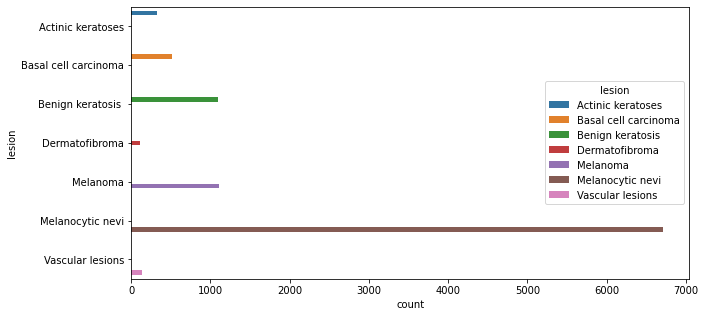

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y='lesion',data=df, hue="lesion",ax=ax1)

*데이터* 셋<br>
사실 이거 뭔지 모르겠어서 찾아봐야함

In [ ]:
# fastai 라이브러리의 업데이트 때문에 ImageItemList 대신 ImageList를 사용해야 하며 잘 작동함 
class CustomImageItemList(ImageList):
  #def -> aaa 의 경우 리턴 값이 어떠한 상태인지 명시
    def custom_label(self,df, **kwargs)->'LabelList':
      #customLabel 경로 임의로 넣은 거라서 아마 오류 뜰지도
        "/content/gdrive/MyDrive/SkinCancer_ResNet50_lsh/customLabel.txt"
        file_names=np.vectorize(lambda files: str(files).split('/')[-1][:-4])
        get_labels=lambda x: df.loc[x,'lesion']
        #self.items is an np array of PosixPath objects with each image path
        labels= get_labels(file_names(self.items))
        y = CategoryList(items=labels)
        res = self._label_list(x=self,y=y)
        return res

In [ ]:
def get_data(bs, size):
    train_ds = (CustomImageItemList.from_folder('/content/gdrive/MyDrive/SkinCancer_ResNet50_lsh', extensions='.jpg')
                    .random_split_by_pct(0.15)
                    .custom_label(df)
                    .transform(tfms=get_transforms(flip_vert=True),size=size)
                    .databunch(num_workers=2, bs=bs)
                    .normalize(imagenet_stats))
    return train_ds

In [ ]:
data=get_data(16,224)

/usr/local/lib/python3.7/dist-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")
/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/l

In [ ]:
data.classes=list(np.unique(df.lesion))  
data.c= len(np.unique(df.lesion))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

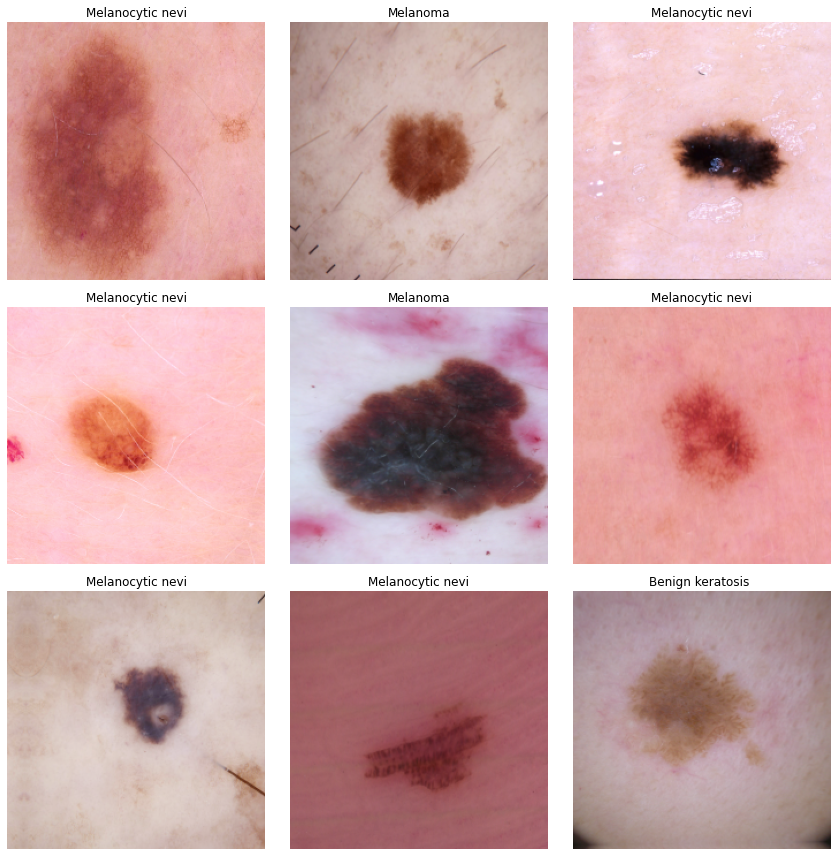

In [ ]:
data.show_batch(rows=3)

Model ResNet50

In [ ]:
learner=create_cnn(data,models.resnet50,metrics=[accuracy], model_dir="/tmp/model/")

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
learner.loss_func=nn.CrossEntropyLoss()

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


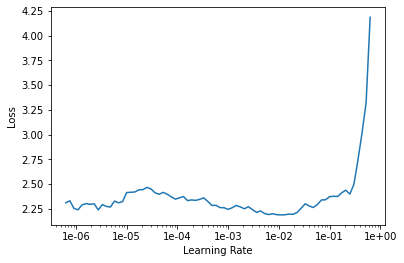

In [ ]:
learner.lr_find()
learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(10, 3e-3)

In [ ]:
learner.unfreeze()

In [ ]:
learner.lr_find()
learner.recorder.plot()

In [ ]:
lr=1e-6
learner.fit_one_cycle(3, slice(3*lr,10*lr))

In [ ]:
learner.save('stage-1')

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

In [ ]:
nterp.plot_confusion_matrix(figsize=(10,8))

In [ ]:
interp.most_confused()